In [1]:
import pandas as pd
import numpy as np

# data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image

# model fit
import statsmodels.api as sm
import tensorflow as tf

# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')

2023-11-05 15:07:49.370804: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-05 15:07:49.416468: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-05 15:07:49.417268: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-05 15:07:50.176836: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Read agricultural data into pandas df

In [2]:
#Read CSV into dataframe
ag_data = pd.read_csv('Agrofood_co2_emission.csv')

#Format column headers
ag_data.columns = ag_data.columns.str.replace(' -', '')
ag_data.columns = ag_data.columns.str.replace('(', '', regex=True)
ag_data.columns = ag_data.columns.str.replace(')', '', regex=True)
ag_data.columns = ag_data.columns.str.replace(' ', '_')
ag_data.columns = map(str.lower, ag_data.columns)


ag_data.head()

,area,year,savanna_fires,forest_fires,crop_residues,rice_cultivation,drained_organic_soils_co2,pesticides_manufacturing,food_transport,forestland,...,manure_management,fires_in_organic_soils,fires_in_humid_tropical_forests,on-farm_energy_use,rural_population,urban_population,total_population_male,total_population_female,total_emission,average_temperature_°c
0,Afghanistan,1990,14.7237,0.0557,205.6077,686.00,0.0,11.807483,63.1152,-2388.803,...,319.1763,0.0,0.0,NaN,9655167.0,2593947.0,5348387.0,5346409.0,2198.963539,0.536167
1,Afghanistan,1991,14.7237,0.0557,209.4971,678.16,0.0,11.712073,61.2125,-2388.803,...,342.3079,0.0,0.0,NaN,10230490.0,2763167.0,5372959.0,5372208.0,2323.876629,0.020667
2,Afghanistan,1992,14.7237,0.0557,196.5341,686.00,0.0,11.712073,53.3170,-2388.803,...,349.1224,0.0,0.0,NaN,10995568.0,2985663.0,6028494.0,6028939.0,2356.304229,-0.259583
3,Afghanistan,1993,14.7237,0.0557,230.8175,686.00,0.0,11.712073,54.3617,-2388.803,...,352.2947,0.0,0.0,NaN,11858090.0,3237009.0,7003641.0,7000119.0,2368.470529,0.101917
4,Afghanistan,1994,14.7237,0.0557,242.0494,705.60,0.0,11.712073,53.9874,-2388.803,...,367.6784,0.0,0.0,NaN,12690115.0,3482604.0,7733458.0,7722096.0,2500.768729,0.372250


In [3]:
# ag_data.info()
ag_data.shape

(6965, 31)

### Drop Unecessary Columns:
total emissions, rural population, male population, female population

In [4]:
ag_data = ag_data.drop(['total_emission','total_population_female', 'total_population_male', 'rural_population'], axis=1)

In [5]:
# ag_data.info()
ag_data.shape

(6965, 27)

### Combine similar columns:

fires = savanna_fires + forest_fires + fires_in_organic_soils + fires_in_humid_tropical_forests
</br>manure_mgmt = manure_applied_to_soils + manure_left_on_pasture + manure_management
</br>food_systems = food_processing + food_packaging + food_retail + food_transport + food_houshold_consumption + agrifood_systems_waste_disposal
</br>ippu_tot = ippu + pesticides_manufacturing + fertilizers_manufacturing
</br>on_farm_energy_use = on-farm_electricity_use + on-farm_energy_use

In [6]:
ag_data['fires'] = ag_data['savanna_fires']+ag_data['forest_fires']+ag_data['fires_in_organic_soils']+ag_data['fires_in_humid_tropical_forests']
ag_data['manure_mgmt'] = ag_data['manure_applied_to_soils']+ag_data['manure_left_on_pasture']+ag_data['manure_management']
ag_data['food_systems'] = ag_data['food_processing']+ag_data['food_packaging']+ag_data['food_retail']+ag_data['food_transport']+ag_data['food_household_consumption']+ag_data['agrifood_systems_waste_disposal']
ag_data['ippu_tot'] = ag_data['ippu']+ag_data['pesticides_manufacturing']+ag_data['fertilizers_manufacturing']
ag_data['on_farm_energy_use'] = ag_data['on-farm_electricity_use'] + ag_data['on-farm_energy_use']

In [7]:
#Drop individual columns
ag_data = ag_data.drop(['savanna_fires', 'forest_fires', 'fires_in_organic_soils', 'fires_in_humid_tropical_forests',
                       'manure_applied_to_soils', 'manure_left_on_pasture', 'manure_management', 'food_processing',
                       'food_packaging', 'food_retail', 'food_transport', 'food_household_consumption',
                       'agrifood_systems_waste_disposal', 'ippu', 'pesticides_manufacturing', 'fertilizers_manufacturing',
                       'on-farm_electricity_use', 'on-farm_energy_use'], axis=1)

In [8]:
# ag_data.info()
ag_data.shape

(6965, 14)

### Read Multivariate ENSO Index (MEI) data into pandas df

In [9]:
enso_data = pd.read_csv('meiv2.csv')
enso_data.columns = map(str.lower, enso_data.columns)

#Drop years before 1990 and after 2020
enso_data = enso_data[enso_data['year'] <= 2020]
enso_data = enso_data[enso_data['year'] > 1989]

enso_data = enso_data.set_index('year')

#Calculate yearly average index
enso_data['mei'] = enso_data.mean(axis=1)

#Reset index
enso_data = enso_data.reset_index(names=['year'])

#Drop months columns
enso_data = enso_data.drop(["dj",'jf','fm','ma','am','mj','jj','ja','as','so','on','nd'], axis='columns')

### Join DFs

In [10]:
ag_data = ag_data.merge(enso_data, left_on='year', right_on='year')

In [11]:
ag_data.head()

,area,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,urban_population,average_temperature_°c,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use,mei
0,Afghanistan,1990,205.6077,686.000000,0.0000,-2388.8030,0.0000,2593947.0,0.536167,14.7794,2169.8513,1263.479256,233.782283,NaN,0.2
1,Albania,1990,59.2391,23.520000,110.5705,72.8581,0.0000,1195379.0,0.735750,12.5814,1054.6462,650.148524,1125.636617,366.090800,0.2
2,Algeria,1990,164.2776,4.312000,0.0000,-111.1403,684.9333,13496502.0,1.005583,144.6946,2758.8447,13250.763265,5288.278000,141.633800,0.2
3,American Samoa,1990,NaN,926.342278,0.0000,-58.8991,7.9612,38076.0,0.566500,0.0000,NaN,199.688951,NaN,58.504263,0.2
4,Andorra,1990,NaN,926.342278,0.0000,0.0000,0.0000,51627.0,1.278500,0.0000,NaN,570.011357,1711.187476,74.704263,0.2


In [12]:
# ag_data.info()
ag_data.shape

(6965, 15)

### Compute rolling totals & Add new columns

In [13]:
def calc_rolling_total(df, column, time_period):
    return (df
            .groupby('area')[column]
            .transform(lambda df: df.rolling(time_period).sum()))

In [14]:
cols = ['crop_residues', 'rice_cultivation', 'drained_organic_soils_co2',
       'net_forest_conversion', 'fires', 'manure_mgmt', 'food_systems',
       'ippu_tot', 'on_farm_energy_use', 'forestland']

In [15]:
for col in cols:
    ag_data['5yr_'+str(col)] = calc_rolling_total(ag_data, col, 5)

In [16]:
for col in cols:
    ag_data['10yr_'+str(col)] = calc_rolling_total(ag_data, col, 10)

In [17]:
for col in cols:
    ag_data['20yr_'+str(col)] = calc_rolling_total(ag_data, col, 20)

In [18]:
ag_data.tail()

,area,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,urban_population,average_temperature_°c,fires,...,20yr_crop_residues,20yr_rice_cultivation,20yr_drained_organic_soils_co2,20yr_net_forest_conversion,20yr_fires,20yr_manure_mgmt,20yr_food_systems,20yr_ippu_tot,20yr_on_farm_energy_use,20yr_forestland
6960,Wallis and Futuna Islands,2020,NaN,4112.742030,0.0000,0.0000,0.0000,0.0,1.232333,0.0000,...,NaN,76096.804360,0.0000,85.6090,0.000000e+00,NaN,NaN,NaN,10990.711434,-72.6645
6961,Western Sahara,2020,NaN,926.342278,0.0000,-104.5657,0.0000,518663.0,2.068000,0.0000,...,NaN,18526.845569,0.0000,409.9035,0.000000e+00,NaN,NaN,NaN,NaN,-4814.5545
6962,Yemen,2020,42.7411,796.196122,0.0000,0.0000,0.0000,11465414.0,1.320126,0.0000,...,1160.2533,13901.882040,0.0000,0.0000,1.869000e-01,55674.2276,143609.988473,42715.266455,37923.032213,0.0000
6963,Zambia,2020,205.7266,48.521800,14566.6658,0.0000,19047.2568,8336381.0,0.714417,54929.7826,...,2581.0404,839.905100,290382.9257,226684.9640,1.105177e+06,39116.5827,45443.238148,28787.794031,1823.799100,0.0000
6964,Zimbabwe,2020,108.3022,7.973300,0.0000,76500.2982,10662.4408,5700460.0,0.189000,530.3224,...,2140.8887,86.071700,0.0000,213443.0780,4.251108e+04,62779.7183,40474.674000,45336.574844,36274.854100,388368.0030


### Reorder Columns

In [19]:
reordered_cols = ['area', 'year', 'urban_population', 'mei', 'crop_residues',
       'rice_cultivation', 'drained_organic_soils_co2',
       'net_forest_conversion', 'fires', 'manure_mgmt', 'food_systems',
       'ippu_tot', 'on_farm_energy_use', 'forestland',
       '5yr_crop_residues', '5yr_rice_cultivation',
       '5yr_drained_organic_soils_co2', '5yr_net_forest_conversion',
       '5yr_fires', '5yr_manure_mgmt', '5yr_food_systems', '5yr_ippu_tot',
       '5yr_on_farm_energy_use', '5yr_forestland', '10yr_crop_residues',
       '10yr_rice_cultivation', '10yr_drained_organic_soils_co2',
       '10yr_net_forest_conversion', '10yr_fires', '10yr_manure_mgmt',
       '10yr_food_systems', '10yr_ippu_tot', '10yr_on_farm_energy_use',
       '10yr_forestland', '20yr_crop_residues', '20yr_rice_cultivation',
       '20yr_drained_organic_soils_co2', '20yr_net_forest_conversion',
       '20yr_fires', '20yr_manure_mgmt', '20yr_food_systems', '20yr_ippu_tot',
       '20yr_on_farm_energy_use', '20yr_forestland', 'average_temperature_°c']
ag_data = ag_data[reordered_cols]

ag_data.head()

,area,year,urban_population,mei,crop_residues,rice_cultivation,drained_organic_soils_co2,net_forest_conversion,fires,manure_mgmt,...,20yr_rice_cultivation,20yr_drained_organic_soils_co2,20yr_net_forest_conversion,20yr_fires,20yr_manure_mgmt,20yr_food_systems,20yr_ippu_tot,20yr_on_farm_energy_use,20yr_forestland,average_temperature_°c
0,Afghanistan,1990,2593947.0,0.2,205.6077,686.000000,0.0000,0.0000,14.7794,2169.8513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.536167
1,Albania,1990,1195379.0,0.2,59.2391,23.520000,110.5705,0.0000,12.5814,1054.6462,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.735750
2,Algeria,1990,13496502.0,0.2,164.2776,4.312000,0.0000,684.9333,144.6946,2758.8447,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.005583
3,American Samoa,1990,38076.0,0.2,NaN,926.342278,0.0000,7.9612,0.0000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.566500
4,Andorra,1990,51627.0,0.2,NaN,926.342278,0.0000,0.0000,0.0000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.278500


### Evaluate Countries with fewer than 31 years:

In [20]:
ag_data_area = ag_data.groupby('area').sum()
ag_data_area.loc[ag_data_area['year'] != 62155]

,year,urban_population,mei,crop_residues,rice_cultivation,drained_organic_soils_co2,net_forest_conversion,fires,manure_mgmt,food_systems,...,20yr_rice_cultivation,20yr_drained_organic_soils_co2,20yr_net_forest_conversion,20yr_fires,20yr_manure_mgmt,20yr_food_systems,20yr_ippu_tot,20yr_on_farm_energy_use,20yr_forestland,average_temperature_°c
area,,,,,,,,,,,,,,,,,,,,,
Armenia,58174,5.635726e+07,-2.933333,867.9864,7193.783413,0.000000e+00,2917.1471,147.4283,12704.6754,3.341263e+04,...,49612.299402,0.000000e+00,2.511534e+04,1.021186e+03,8.683991e+04,2.402362e+05,2.341487e+05,4.309982e+04,-9.507903e+03,30.398333
Azerbaijan,58174,1.347994e+08,-2.933333,4224.8868,540.850300,0.000000e+00,4081.8835,869.7217,57311.7177,1.505620e+05,...,3688.180100,0.000000e+00,2.489823e+04,5.946817e+03,4.007650e+05,1.053898e+06,3.589915e+05,3.025475e+05,-4.200900e+05,30.718750
Belarus,58174,2.051809e+08,-2.933333,12870.7709,26863.926076,1.237739e+06,44432.5316,1139.1979,118212.6124,2.316582e+05,...,185268.455694,8.567048e+06,2.749150e+05,7.997382e+03,7.835883e+05,1.578719e+06,2.684695e+06,6.429565e+05,-9.714638e+06,43.376000
Belgium,42210,2.241269e+08,-4.991667,3792.0467,15238.494610,4.233712e+03,13283.4030,1.7183,79432.2159,2.515535e+05,...,29045.246731,8.053790e+03,2.556220e+04,3.144200e+00,1.509388e+05,4.814215e+05,7.779817e+05,9.600227e+04,-1.184382e+05,31.193667
Belgium-Luxembourg,19945,1.015337e+08,2.933333,1530.0201,7733.039548,2.170152e+03,10069.1510,1.6377,45740.5605,0.000000e+00,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.839917
Bosnia and Herzegovina,58174,4.783055e+07,-2.933333,1935.6795,7215.045405,3.432881e+03,0.0000,663.6878,22613.4146,6.318621e+04,...,49781.178583,2.390168e+04,0.000000e+00,4.785739e+03,1.579365e+05,4.498566e+05,3.145279e+05,1.423080e+04,-4.063234e+03,34.322833
Croatia,58174,6.917302e+07,-2.933333,4609.2055,16056.151542,2.582154e+02,8217.6994,358.3903,26695.2161,7.960718e+04,...,110494.201525,1.783300e+03,4.877220e+04,2.370251e+03,1.840568e+05,5.860312e+05,8.951503e+05,1.660167e+05,-2.977776e+05,36.427000
Czechia,56182,2.156180e+08,-4.125000,12395.6109,24001.145653,7.543190e+03,18459.6918,16.0832,47520.7339,3.448612e+05,...,153375.093185,4.830795e+04,1.225554e+05,1.088061e+02,2.950132e+05,2.246829e+06,1.467291e+06,3.822967e+05,-1.338620e+06,38.685250
Czechoslovakia,5973,3.234779e+07,2.066667,2158.5798,2779.026835,1.048374e+03,2036.8200,2.8005,14987.4518,2.195435e+04,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.250750


### Drop Belgium-Luxembourg

Not sure why Belgium & Luxembourg are reported together between 1990 and 2000, but not sure how to accurately split info for these years into each country. Propose dropping these data points. 

In [21]:
# ag_data[ag_data['area'] == 'Belgium']
# ag_data[ag_data['area'] == 'Luxembourg']
# ag_data[ag_data['area'] == 'Belgium-Luxembourg']

ag_data = ag_data[ag_data['area'] != 'Belgium-Luxembourg']

### Drop Czechoslovakia

Czeochoslovakia split into Czechia (Czech Republic) & Slovakia in 1993. Czechoslavakia data between 1990-1992 represents the entire region. Only lose 3 years of data. 

In [22]:
# ag_data[ag_data['area'] == 'Czechia']
# ag_data[ag_data['area'] == 'Czechoslovakia']
# ag_data[ag_data['area'] == 'Slovakia']

ag_data = ag_data[ag_data['area'] != 'Czechoslovakia']

### Drop USSR

Soviet Union fell in 1991. Drop 1990-1991. 

In [23]:
# ag_data[ag_data['area'] == 'USSR']
    
ag_data = ag_data[ag_data['area'] != 'USSR']

### Drop Yugoslavia SFR

SFRY ended in 1991

In [24]:
# ag_data[ag_data['area'] == 'Yugoslav SFR']

ag_data = ag_data[ag_data['area'] != 'Yugoslav SFR']

### Drop Pacific Islands Trust Territory

Split into Micronesia, Marshall Islands, and Palau. Only drop 1990.

In [25]:
# ag_data[ag_data['area'] == 'Pacific Islands Trust Territory']

ag_data = ag_data[ag_data['area'] != 'Pacific Islands Trust Territory']

### Rename Ethiopia PDR to Ethiopia

In [26]:
#ag_data[ag_data['area'] == 'Ethiopia PDR']
#ag_data[ag_data['area'] == 'Ethiopia']

ag_data.loc[ag_data["area"] == "Ethiopia PDR", 'area'] = "Ethiopia"

### Drop Serbia, Montenegro, Serbia & Montenegro

These countries were in a union until 2006. Very difficult to split or interpret this data. Not enough data left if we remove Serbia & Montenegro data points. Propose removing all 3 from datasest. 

In [27]:
ag_data = ag_data[ag_data['area'] != 'Serbia']
ag_data = ag_data[ag_data['area'] != 'Montenegro']
ag_data = ag_data[ag_data['area'] != 'Serbia and Montenegro']

### Drop Sudan(former), Sudan, and South Sudan

Split into two countries in 2011. Very difficult to split or interpret data prior to split. Propose removing all 3 from dataset. 

In [28]:
ag_data = ag_data[ag_data['area'] != 'Sudan (former)']
ag_data = ag_data[ag_data['area'] != 'Sudan']
ag_data = ag_data[ag_data['area'] != 'South Sudan']

### Drop Netherlands Antiles

Was a country made up of dutch colonized islands. Dissolved in 2010. Not sufficient data to keep. Propose removing. 

In [29]:
ag_data = ag_data[ag_data['area'] != 'Netherlands Antilles (former)']

### One-hot encoding

Create one-hot encodings to classify "areas" column

In [30]:
# One hot encoding "area"
area_dummies = pd.get_dummies(
    ag_data['area'],
    drop_first = True)

# add to initial df
ag_data = pd.concat(
    [ag_data, area_dummies],
    axis=1
)

ag_data.head()

,area,year,urban_population,mei,crop_residues,rice_cultivation,drained_organic_soils_co2,net_forest_conversion,fires,manure_mgmt,...,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Wallis and Futuna Islands,Western Sahara,Yemen,Zambia,Zimbabwe
0,Afghanistan,1990,2593947.0,0.2,205.6077,686.000000,0.0000,0.0000,14.7794,2169.8513,...,0,0,0,0,0,0,0,0,0,0
1,Albania,1990,1195379.0,0.2,59.2391,23.520000,110.5705,0.0000,12.5814,1054.6462,...,0,0,0,0,0,0,0,0,0,0
2,Algeria,1990,13496502.0,0.2,164.2776,4.312000,0.0000,684.9333,144.6946,2758.8447,...,0,0,0,0,0,0,0,0,0,0
3,American Samoa,1990,38076.0,0.2,NaN,926.342278,0.0000,7.9612,0.0000,NaN,...,0,0,0,0,0,0,0,0,0,0
4,Andorra,1990,51627.0,0.2,NaN,926.342278,0.0000,0.0000,0.0000,NaN,...,0,0,0,0,0,0,0,0,0,0


### Split train, validation, and test data

~ 70% (1990-2010)
</br>~ 15% (2011-2015)
</br>~ 15% (2016-2020)

In [31]:
train = ag_data[ag_data['year'] <= 2010]
val = ag_data[(ag_data['year'] > 2010) & (ag_data['year'] <= 2015)]
test = ag_data[ag_data['year'] > 2015]

### Standaradize input variables in training datset

In [32]:
#Create a list of all features that need to be standardized
features = ['urban_population', 'mei', 'crop_residues', 'rice_cultivation', 'drained_organic_soils_co2', 'net_forest_conversion', 'fires',
            'manure_mgmt', 'food_systems', 'ippu_tot', 'on_farm_energy_use', 'forestland', '5yr_crop_residues', '5yr_rice_cultivation',
            '5yr_drained_organic_soils_co2', '5yr_net_forest_conversion', '5yr_fires', '5yr_manure_mgmt', '5yr_food_systems', '5yr_ippu_tot',
            '5yr_on_farm_energy_use', '5yr_forestland', '10yr_crop_residues', '10yr_rice_cultivation', '10yr_drained_organic_soils_co2',
            '10yr_net_forest_conversion', '10yr_fires', '10yr_manure_mgmt', '10yr_food_systems', '10yr_ippu_tot', '10yr_on_farm_energy_use',
            '10yr_forestland', '20yr_crop_residues', '20yr_rice_cultivation', '20yr_drained_organic_soils_co2', '20yr_net_forest_conversion',
            '20yr_fires', '20yr_manure_mgmt', '20yr_food_systems', '20yr_ippu_tot', '20yr_on_farm_energy_use', '20yr_forestland']

In [33]:
#Standardize train dataset

scaler = StandardScaler()
scaler.fit(train[features])
train[features] = scaler.transform(train[features])

In [34]:
#Standardize val and test datasets using train mean and st deviation

val[features] = scaler.transform(val[features])
test[features] = scaler.transform(test[features])

In [40]:
#Verify standardization was performed correctly
train[features].describe()
val[features].describe()
test[features].describe()

,urban_population,mei,crop_residues,rice_cultivation,drained_organic_soils_co2,net_forest_conversion,fires,manure_mgmt,food_systems,ippu_tot,...,20yr_crop_residues,20yr_rice_cultivation,20yr_drained_organic_soils_co2,20yr_net_forest_conversion,20yr_fires,20yr_manure_mgmt,20yr_food_systems,20yr_ippu_tot,20yr_on_farm_energy_use,20yr_forestland
count,1115.000000,1115.000000,889.000000,1115.000000,1115.000000,1035.000000,1090.000000,968.000000,1045.000000,995.000000,...,879.000000,1109.000000,1109.000000,1029.000000,1084.000000,962.000000,1037.000000,989.000000,954.000000,1029.000000
mean,0.131785,-0.178304,0.089789,0.006956,0.016630,-0.046258,-0.028964,0.040563,0.113860,0.202881,...,0.017146,-0.021902,0.024764,-0.037387,-0.023589,-0.001191,0.030607,0.087336,0.005804,-0.041207
std,1.612919,0.647697,1.319316,1.004728,1.159786,0.564867,0.662817,1.043775,1.652160,2.209680,...,1.053523,0.942685,1.056103,0.795371,0.890833,0.981887,1.246227,1.601530,1.065845,1.284939
min,-0.272117,-0.871103,-0.270725,-0.241916,-0.225647,-0.168273,-0.148591,-0.335569,-0.261064,-0.213265,...,-0.274666,-0.254175,-0.207115,-0.180617,-0.196939,-0.336283,-0.275523,-0.237041,-0.245986,-11.361515
25%,-0.266259,-0.737405,-0.267350,-0.228015,-0.225647,-0.168273,-0.148591,-0.324154,-0.252590,-0.197696,...,-0.270748,-0.241848,-0.207115,-0.180617,-0.196938,-0.325573,-0.267633,-0.222790,-0.244119,0.186759
50%,-0.212079,-0.470009,-0.234305,-0.208899,-0.225647,-0.168003,-0.148448,-0.253321,-0.216103,-0.179988,...,-0.242285,-0.224480,-0.207115,-0.178646,-0.196503,-0.267151,-0.238426,-0.205321,-0.230792,0.241007
75%,-0.082979,0.478031,-0.145263,-0.154595,-0.180338,-0.129796,-0.135962,-0.048895,-0.121734,-0.075859,...,-0.167835,-0.168999,-0.162805,-0.126164,-0.179968,-0.086910,-0.161308,-0.134505,-0.153612,0.243213
max,16.026816,0.708964,9.557272,8.367063,15.726281,5.540033,16.215968,7.415034,16.504361,23.050487,...,7.650233,7.651555,14.146306,10.870363,12.916306,7.104265,12.496726,16.760583,9.144173,1.403599


In [44]:
#Confirm size of train, val, and test datasets

print(train.shape)
print(val.shape)
print(test.shape)

(4612, 267)
(1115, 267)
(1115, 267)


### Export Train, Val, Test Data to CSV

In [66]:
train.to_csv('train_data.csv',index=False)
val.to_csv('val_data.csv',index=False)
test.to_csv('test_data.csv',index=False)

### EDA:Train Data

In [58]:
feat = ['urban_population', 'mei', 'crop_residues', 'rice_cultivation', 'drained_organic_soils_co2', 'net_forest_conversion', 'fires',
            'manure_mgmt', 'food_systems', 'ippu_tot', 'on_farm_energy_use', 'forestland', '5yr_crop_residues', '5yr_rice_cultivation',
            '5yr_drained_organic_soils_co2', '5yr_net_forest_conversion', '5yr_fires', '5yr_manure_mgmt', '5yr_food_systems', '5yr_ippu_tot',
            '5yr_on_farm_energy_use', '5yr_forestland', '10yr_crop_residues', '10yr_rice_cultivation', '10yr_drained_organic_soils_co2',
            '10yr_net_forest_conversion', '10yr_fires', '10yr_manure_mgmt', '10yr_food_systems', '10yr_ippu_tot', '10yr_on_farm_energy_use',
            '10yr_forestland', '20yr_crop_residues', '20yr_rice_cultivation', '20yr_drained_organic_soils_co2', '20yr_net_forest_conversion',
            '20yr_fires', '20yr_manure_mgmt', '20yr_food_systems', '20yr_ippu_tot', '20yr_on_farm_energy_use', '20yr_forestland']
feat_5yr = ['average_temperature_°c', '5yr_crop_residues', '5yr_rice_cultivation','5yr_manure_mgmt', '5yr_food_systems', '5yr_ippu_tot']
feat_10yr = ['average_temperature_°c', '10yr_crop_residues', '10yr_rice_cultivation', '10yr_manure_mgmt', '10yr_food_systems', '10yr_ippu_tot']

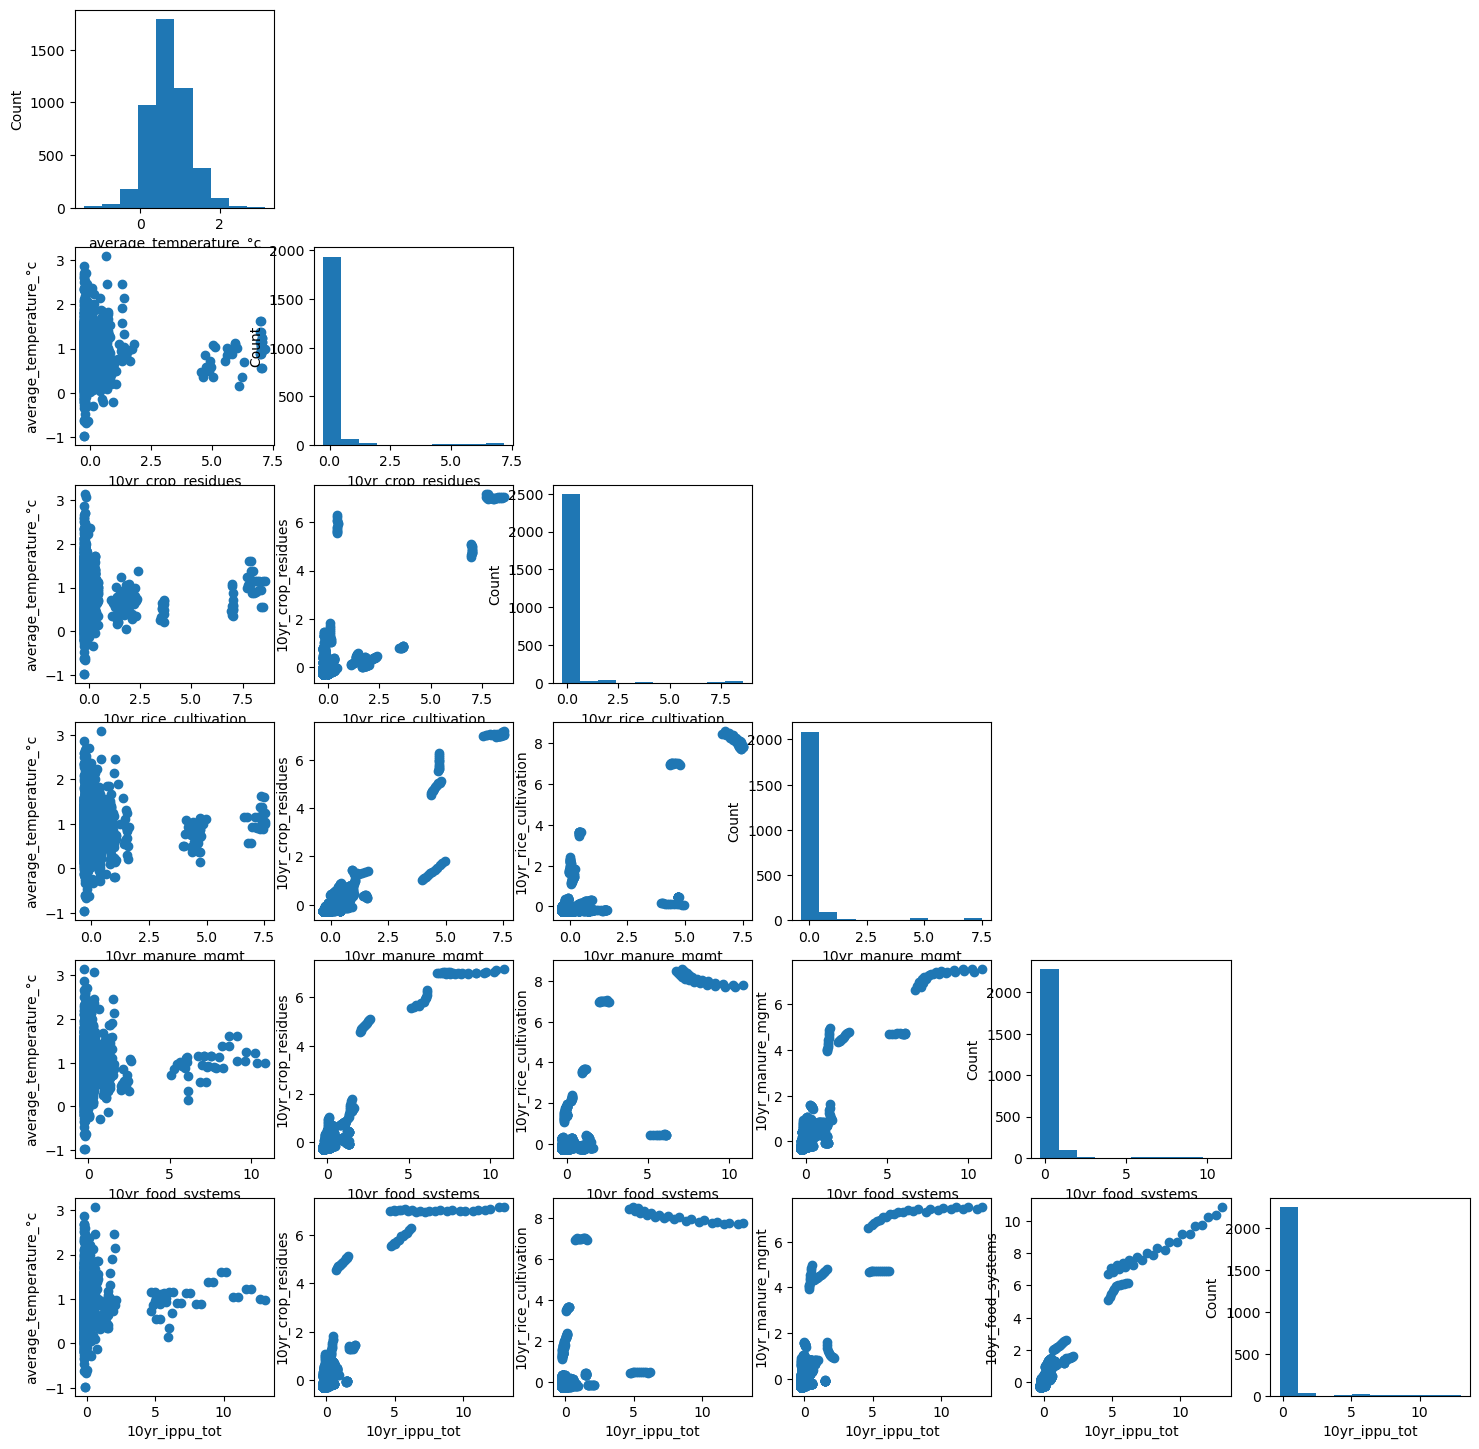

In [59]:
#Print correlation matrix
# print(ag_data[variables].corr())

#Print correlation matrix plots
# sns.pairplot(train[features])

scatterplotmatrix(
    train[feat_10yr].values,
    names=feat_10yr,
    figsize=(18,18), alpha=1
);

### Split X and Y into two dataframes 

Split input variables from output variable (temperature)

In [60]:
x_train = train.drop(['average_temperature_°c'], axis=1)
x_val = val.drop(['average_temperature_°c'], axis=1)
x_test = test.drop(['average_temperature_°c'], axis=1)

Y_train = pd.DataFrame(train['average_temperature_°c'])
Y_val = pd.DataFrame(val['average_temperature_°c'])
Y_test = pd.DataFrame(test['average_temperature_°c'])

In [63]:
print(x_train.shape)
print(Y_train.shape)

print(x_val.shape)
print(Y_val.shape)

print(x_test.shape)
print(Y_test.shape)

(4612, 266)
(4612, 1)
(1115, 266)
(1115, 1)
(1115, 266)
(1115, 1)
